# Flatiron School Phase 3 Project

Student name: **Angelo Turri**

Student pace: **self paced**

Project finish date: **?**

Instructor name: **Mark Barbour**

Blog post URL: **?**

# Stakeholder

A charity organization has a list of Tanzanian water pumps. These pumps can either be entirely functional, functional with some defects in need of repair, or totally non-functional. This organization wants to fix as many of these pumps as it can. However, they have limited funds. To make the most of these funds, they need to be as efficient as possible – this means dispatching only what is necessary to each waterpoint to get the job done. In this hypothetical scenario, non functional water pumps require significantly more resources to repair than functional-needs-repair water pumps.

It is our job to use our available data to make predictions about the waterpoints that this charity organization gave us. The organization wants us to remember that non-functional waterpoints cost more to fix than functional-needs-repair waterpoints. We need to distinguish between them to the best of our ability.

# Data Origin & Description

The data was taken from **https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/**

Descriptions of any of the original variables can be found **below in the dictionary**. These descriptions are also provided here **https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/**.

# Rationale & Limitations

Why are you using **method**?

What about the current problem makes **method** suitable?

Assumptions of our model


Kind of data used

In [168]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, get_scorer_names, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from xgboost import XGBClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from statistics import mode as md
from matplotlib import pyplot as plt
from IPython.display import clear_output, display_html 
from collections import Counter
from pprint import pprint
from itertools import product
import scipy.stats as ss
import researchpy as rp

# Suppresses needless warnings
import warnings
warnings.filterwarnings("ignore")

In [169]:
# For aesthetics

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [170]:
# Importing data
# testing is for the online competition only; it's not directly relevant to this project

testing = pd.read_csv("tanzanian_water_wells/X_test.csv")
X = pd.read_csv("tanzanian_water_wells/X_train.csv")
y = pd.read_csv("tanzanian_water_wells/y_train.csv")['status_group'].map({'functional': 2, 'functional needs repair': 1, 'non functional': 0})

idx = pd.read_csv("tanzanian_water_wells/X_test.csv")['id']

In [171]:
# Random state for any function in the notebook that uses one.
# This is for reproducibility.

state = 42

# Feature Selection

There are quite a few features in this dataset (40). The descriptions of each of these features was taken from Kaggle and listed below. We will not be using all the features, for several reasons:

- Some do not correlate with the target variable (status_group), e.g., the row ID;
- Others have too many categories;
- Some variables differ massively in their values from one dataset to another;
- Others are near copies of different variables in the same dataset, making it pointless to use them.

In [172]:
desc = {'amount_tsh': 'Total static head (amount water available to waterpoint)',
        'date_recorded': 'The date the row was entered',
        'funder': 'Who funded the well',
        'gps_height': 'Altitude of the well',
        'installer': 'Organization that installed the well', 
        'id': 'unique identifier of waterpoint',
        'longitude': 'GPS coordinate',
        'latitude': 'GPS coordinate',
        'wpt_name': 'Name of the waterpoint if there is one',
        'subvillage': 'Geographic location',
        'region': 'Geographic location',
        'region_code': 'Geographic location (coded)',
        'district_code': 'Geographic location (coded)',
        'lga': 'Geographic location',
        'ward': 'Geographic location',
        'population': 'Population around the well',
        'public_meeting': 'True/False',
        'recorded_by': 'Group entering this row of data',
        'scheme_management': 'Who operates the waterpoint',
        'scheme_name': 'Who operates the waterpoint',
        'permit': 'If the waterpoint is permitted',
        'construction_year': 'Year the waterpoint was constructed',
        'extraction_type': 'The kind of extraction the waterpoint uses',
        'extraction_type_group': 'The kind of extraction the waterpoint uses',
        'extraction_type_class': 'The kind of extraction the waterpoint uses',
        'management': 'How the waterpoint is managed',
        'management_group': 'How the waterpoint is managed',
        'payment': 'What the water costs',
        'payment_type': 'What the water costs',
        'water_quality': 'The quality of the water',
        'quality_group': 'The quality of the water',
        'quantity': 'The quantity of water',
        'quantity_group': 'The quantity of water',
        'source': 'The source of the water',
        'source_type': 'The source of the water',
        'source_class': 'The source of the water',
        'waterpoint_type': 'The kind of waterpoint',
        'waterpoint_type_group': 'The kind of waterpoint'
    }

### Variable inconsistency across train and test sets

We were given two datasets for analysis – one training dataset, complete with feature and target variables, and a testing dataset, which only had the feature variables (the target values were hidden).

Our goal is to accurately predict the target values in the test dataset. To do this successfully, we must use features in our model that correlate well with the target.

Unfortunately, some of our categorical variables differ in their categories from one dataset to another. Therefore, any model that uses these variables will have less success in the test dataset than in the training dataset - because it will come across numerous unknown categories.

It seems like the following variables should be removed from our features:

- wpt_name
- subvillage
- installer
- funder
- scheme_name
- ward
- date_recorded

In [173]:
differences = []

columns = list(X.select_dtypes(exclude=['float64', 'int64']).columns)

for col in columns:
    
    # This finds all the differences between two sets
    difference = set(list(X[col])) ^ set(list(testing[col]))
    differences.append(len(difference))
    
differences_df = pd.DataFrame({'column': list(columns), 'differences': differences})
differences_df = differences_df.sort_values(by=['differences'], ascending=False)
differences_df.head(10)

,column,differences
3,wpt_name,43128
5,subvillage,15120
2,installer,1584
1,funder,1403
12,scheme_name,1251
8,ward,145
0,date_recorded,51
14,extraction_type,1
23,quantity,0
21,water_quality,0


In [174]:
# Dropping all problem features from both test and train datasets

X = X.drop(list(differences_df['column'])[:7], axis=1)
testing = testing.drop(list(differences_df['column'])[:7], axis=1)

### Dropping variables that do not correlate with the target column

Two variables, namely "id" and "recorded_by", do not correlate with the target column (status_group).

- **id** is a unique numerical identifier for waterpoints; each waterpoint has a different identifier. An identifier such as this one cannot meaningfully correlate with the target column.

- **recorded_by** has only one value in the entire dataset, and therefore cannot correlate with the target column.

In [175]:
X.recorded_by.value_counts()

recorded_by
GeoData Consultants Ltd    59400
Name: count, dtype: int64

In [176]:
X = X.drop(['id', 'recorded_by'], axis=1)
testing = testing.drop(['id', 'recorded_by'], axis=1)

### Checking for collinearity among the variables

We want to eliminate collinearity. These variables might be strongly correlated with each other, based on the names they were given:

- **region** and **region_code**
- **scheme_management** and **scheme_name**
- **extraction_type**, **extraction_type_group** and **extraction_type_class**
- **management** and **management_group**
- **payment** and **payment_type**
- **water_quality** and **quality_group**
- **quantity** and **quantity_group**
- **source**, **source_type** and **source_class**
- **waterpoint_type** and **waterpoint_type_group**

I will search amongst the correlations between all of our features for evidence of collinearity.

In [177]:
# Preprocessing for our training dataset

# Eliminating null values
X.scheme_management.fillna("None", inplace=True)
X.permit.fillna('Unknown', inplace=True)
X.public_meeting.fillna('Unknown', inplace=True)

# Casting certain features as different dtypes
X['permit'] = X['permit'].map({True: 'Yes', False: 'No', 'Unknown': 'Unknown'})
X['gps_height'] = X['gps_height'].astype('float64')
X['population'] = X['population'].astype('float64')
X['construction_year'] = X['construction_year'].astype('int64')
X['region_code'] = X['region_code'].astype('str')
X['district_code'] = X['district_code'].astype('str')

# !!IMPORTANT!!
# Separating features into numeric and categorical dataframes for preprocessing.
X_cat = X.select_dtypes(exclude=['float64', 'int64'])
X_cat = X_cat.astype('str')
oe = OrdinalEncoder()
oe.fit(X_cat)
X_cat = pd.DataFrame(oe.transform(X_cat), 
                     index = X_cat.index, 
                     columns = X_cat.columns)

## !!IMPORTANT!!
# Standardizing numercal features using MinMaxScaler
X_numeric = X.select_dtypes(['float64', 'int64'])
mms = MinMaxScaler()
mms.fit(X_numeric)
X_numeric_copy = X_numeric.copy()
X_numeric = pd.DataFrame(mms.transform(X_numeric), 
                         columns = X_numeric.columns, 
                         index = X_numeric.index)

In [178]:
# A helper function that makes any strong correlations easy to spot

def cts(val):
    if (val > 0.7):
        color = 'red'
    elif (val<-0.7):
        color = 'red'
    else: 
        color = 'black'
    return 'color: %s' % color

In [179]:
# Enables us to see all the correlations in this dataframe, as there are quite a few
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

combs = list(product(list(X_cat.columns), repeat=2))

combs_ps = {x: None for x in combs}
combs_vs = {x: None for x in combs}

for comb in combs:
    col1 = comb[0]
    col2 = comb[1]
    
    crosstab, test_results, expected = rp.crosstab(X_cat[col1], X_cat[col2],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")

    combs_ps[comb] = test_results['results'][1]
    combs_vs[comb] = test_results['results'][2]
    
comb_df = {col: [None for i in X_cat.columns] for col in X_cat.columns}
comb_df = pd.DataFrame(comb_df, index=X_cat.columns)

for v in list(combs_vs.keys()):
    comb_df[v[0]][v[1]] = combs_vs[v]
    
comb_df.style.applymap(cts)

,basin,region,region_code,district_code,lga,public_meeting,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
basin,1.000000,0.767200,0.774000,0.314000,0.907800,0.162700,0.246200,0.270500,0.246100,0.239800,0.250500,0.222200,0.142100,0.245000,0.245000,0.119900,0.139200,0.139000,0.139000,0.245000,0.255000,0.123700,0.208600,0.196600
region,0.767200,1.000000,0.998100,0.325600,1.000000,0.358400,0.365500,0.446900,0.261100,0.291200,0.358400,0.343000,0.222300,0.357500,0.357500,0.199000,0.215400,0.213100,0.213100,0.322000,0.356600,0.221200,0.294500,0.271400
region_code,0.774000,0.998100,1.000000,0.419600,0.972700,0.364800,0.381400,0.457100,0.275700,0.299400,0.369800,0.348100,0.228100,0.368800,0.368800,0.208500,0.227500,0.232500,0.232500,0.335200,0.372700,0.257500,0.301400,0.275400
district_code,0.314000,0.325600,0.419600,1.000000,0.857600,0.187900,0.194200,0.242800,0.119800,0.129400,0.148800,0.145500,0.107900,0.167400,0.167400,0.114600,0.130400,0.152600,0.152600,0.147900,0.165400,0.198300,0.120700,0.118300
lga,0.907800,1.000000,0.972700,0.857600,1.000000,0.580400,0.626600,0.865800,0.389200,0.418700,0.485100,0.561100,0.427400,0.563700,0.563700,0.356300,0.395300,0.421500,0.421500,0.469200,0.508000,0.479700,0.423100,0.404600
public_meeting,0.162700,0.358400,0.364800,0.187900,0.580400,1.000000,0.252900,0.102600,0.130600,0.113300,0.106300,0.270700,0.217300,0.251800,0.251800,0.115500,0.104600,0.146000,0.146000,0.122700,0.100300,0.056100,0.076400,0.076100
scheme_management,0.246200,0.365500,0.381400,0.194200,0.626600,0.252900,1.000000,0.227400,0.193400,0.174600,0.223700,0.749200,0.693300,0.211500,0.211500,0.129200,0.140500,0.166800,0.166800,0.230900,0.277300,0.222000,0.191800,0.205200
permit,0.270500,0.446900,0.457100,0.242800,0.865800,0.102600,0.227400,1.000000,0.170900,0.159200,0.139800,0.175300,0.046800,0.159300,0.159300,0.151600,0.145200,0.076200,0.076200,0.166300,0.162000,0.079100,0.136800,0.117000
extraction_type,0.246100,0.261100,0.275700,0.119800,0.389200,0.130600,0.193400,0.170900,1.000000,1.000000,1.000000,0.167000,0.129300,0.244300,0.244300,0.149100,0.174000,0.123000,0.123000,0.407900,0.483200,0.309600,0.505300,0.536900
extraction_type_group,0.239800,0.291200,0.299400,0.129400,0.418700,0.113300,0.174600,0.159200,1.000000,1.000000,1.000000,0.158100,0.121900,0.242400,0.242400,0.146000,0.170600,0.117100,0.117100,0.393100,0.465200,0.271500,0.504500,0.536600


In [180]:
# Resets the custom visual settings we had in place for Pandas
# If we didn't reset them, pandas would attempt to show every row for large datasets
# This would crash our notebook

pd.reset_option('max_columns')
pd.reset_option('max_rows')

In [181]:
X_numeric.corr().style.applymap(cts)

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
amount_tsh,1.000000,0.076650,0.022134,-0.052670,0.002944,0.016288,0.067915
gps_height,0.076650,1.000000,0.149155,-0.035751,0.007237,0.135003,0.658727
longitude,0.022134,0.149155,1.000000,-0.425802,0.023873,0.086590,0.396732
latitude,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.022152,-0.245278
num_private,0.002944,0.007237,0.023873,0.006837,1.000000,0.003818,0.026056
population,0.016288,0.135003,0.086590,-0.022152,0.003818,1.000000,0.260910
construction_year,0.067915,0.658727,0.396732,-0.245278,0.026056,0.260910,1.000000


### Strong correlations

My threshold for a "strong correlation" is 0.5 here. I realize that is low for some people. However, I have a lot of features – too many at the moment, hence my aggressive approach.

These are the strong correlations we observed among our features:

- gps_height and construction_year
- scheme_management, management and management_group
- extraction, extraction_type_group and extraction_type_class
- payment and payment_type
- quantity and quantity_group
- source and source_type
- waterpoint_type and waterpoint_type_group

Of each of these groups, we must pick only one variable to keep.

### Correlation to status_group using chi-squared test of independence
How do we decide between these variables? I will use the chi-squared test for indepenence to determine how strongly the variables correlate with our target variable, "status_group." Whichever of these variables more strongly correlates with status_group will be used in our models.

In [182]:
groups = [['lga', 'basin', 'region', 'region_code', 'district_code', 'permit'], 
          ['extraction_type', 'extraction_type_group', 'extraction_type_class'], 
          ['management', 'scheme_management', 'management_group'],
          ['payment', 'payment_type'], 
          ['water_quality', 'quality_group'],
          ['quantity', 'quantity_group'], 
          ['source', 'source_type', 'source_class'], 
          ['waterpoint_type', 'waterpoint_type_group']]

for group in groups:
    function = SelectKBest(score_func=chi2, k='all').fit(pd.concat([X_numeric, X_cat], axis=1)[group], y)
    function_results = pd.DataFrame({'feature': function.feature_names_in_, 'score': function.scores_}).sort_values(by=['score'], ascending=False).reset_index(drop=True)
    df = function_results.sort_values(by=['score'], ascending=False)
    display(df)

,feature,score
0,lga,9184.155815
1,region,1805.634614
2,region_code,1788.823521
3,district_code,705.287786
4,basin,266.291881
5,permit,40.261224


,feature,score
0,extraction_type_class,4962.445269
1,extraction_type_group,3427.761791
2,extraction_type,2638.196579


,feature,score
0,scheme_management,310.768525
1,management,176.680250
2,management_group,30.233213


,feature,score
0,payment,866.203572
1,payment_type,462.559171


,feature,score
0,quality_group,422.672708
1,water_quality,0.991495


,feature,score
0,quantity,672.865229
1,quantity_group,672.865229


,feature,score
0,source_type,568.229788
1,source,458.830986
2,source_class,395.059711


,feature,score
0,waterpoint_type,3348.517448
1,waterpoint_type_group,2540.881101


This determines which variables we will keep, and which we will eliminate. The ones we will eliminate are:

- construction_year
- management
- management_group
- extraction_type_group
- extraction_type
- payment_type
- quantity_group (this choice doesn't matter, both are perfectly correlated with each other)
- source
- waterpoint_type_group

In [183]:
# Eliminating problematic categorical features
X_cat = X_cat.drop(['region', 'region_code', 'district_code', 
                    'basin', 'permit', 'extraction_type_group', 
                    'extraction_type', 'management', 'management_group', 
                    'payment_type', 'water_quality', 'quantity_group', 
                    'source', 'source_class', 'waterpoint_type_group' ], axis=1)

for col in X_cat.columns:
    X_cat[col]=X[col]

In [184]:
pvalues = []
statistics = []
effects = []

for col in list(X_numeric.columns):
    
    kruskal = ss.kruskal(X_numeric[col], y)
    
    statistic = kruskal[0]
    
    effect = (statistic - 3 + 1)/(len(y)-3)
    
    pvalue = kruskal[1]
    
    pvalues.append(pvalue)
    effects.append(effect)
    statistics.append(statistic)
    
pd.DataFrame({'kruskal': statistics, 'effect_size': effects, 'pvalue': pvalues}, index=list(X_numeric.columns))

,kruskal,effect_size,pvalue
amount_tsh,27254.126689,0.458813,0.0
gps_height,4935.044758,0.083052,0.0
longitude,5428.781850,0.091365,0.0
latitude,4816.138807,0.081050,0.0
num_private,50569.714929,0.851351,0.0
population,13128.756860,0.221000,0.0
construction_year,12772.789149,0.215007,0.0


In [185]:
pvalues = []
effects = []

for col in list(X_cat.columns):
    
    crosstab, test_results, expected = rp.crosstab(X_cat[col], y,
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")

    pvalue = test_results['results'][1]
    effect = test_results['results'][2]
    
    pvalues.append(pvalue)
    effects.append(effect)
    
comb_df = pd.DataFrame({'effect_size': effects, 'pvalue': pvalues}, index=X_cat.columns)
    
comb_df.style.applymap(cts)

,effect_size,pvalue
lga,0.311500,0.000000
public_meeting,0.056900,0.000000
scheme_management,0.129400,0.000000
extraction_type_class,0.241500,0.000000
payment,0.182700,0.000000
quality_group,0.133000,0.000000
quantity,0.309200,0.000000
source_type,0.126700,0.000000
waterpoint_type,0.250400,0.000000


In [186]:
# Casting all categorical features as string dtypes for simplicity
X_cat = X_cat.astype('str')

X_cat_copy = X_cat.copy()
X_copy = pd.concat([X_numeric_copy, X_cat_copy], axis=1)

X_cat = pd.get_dummies(X_cat, drop_first=True, dtype='int64')
# X_cat = X_cat.drop(['region_code_26.0'], axis=1)

# Combining both numeric and categorical features
X = pd.concat([X_numeric, X_cat], axis=1)

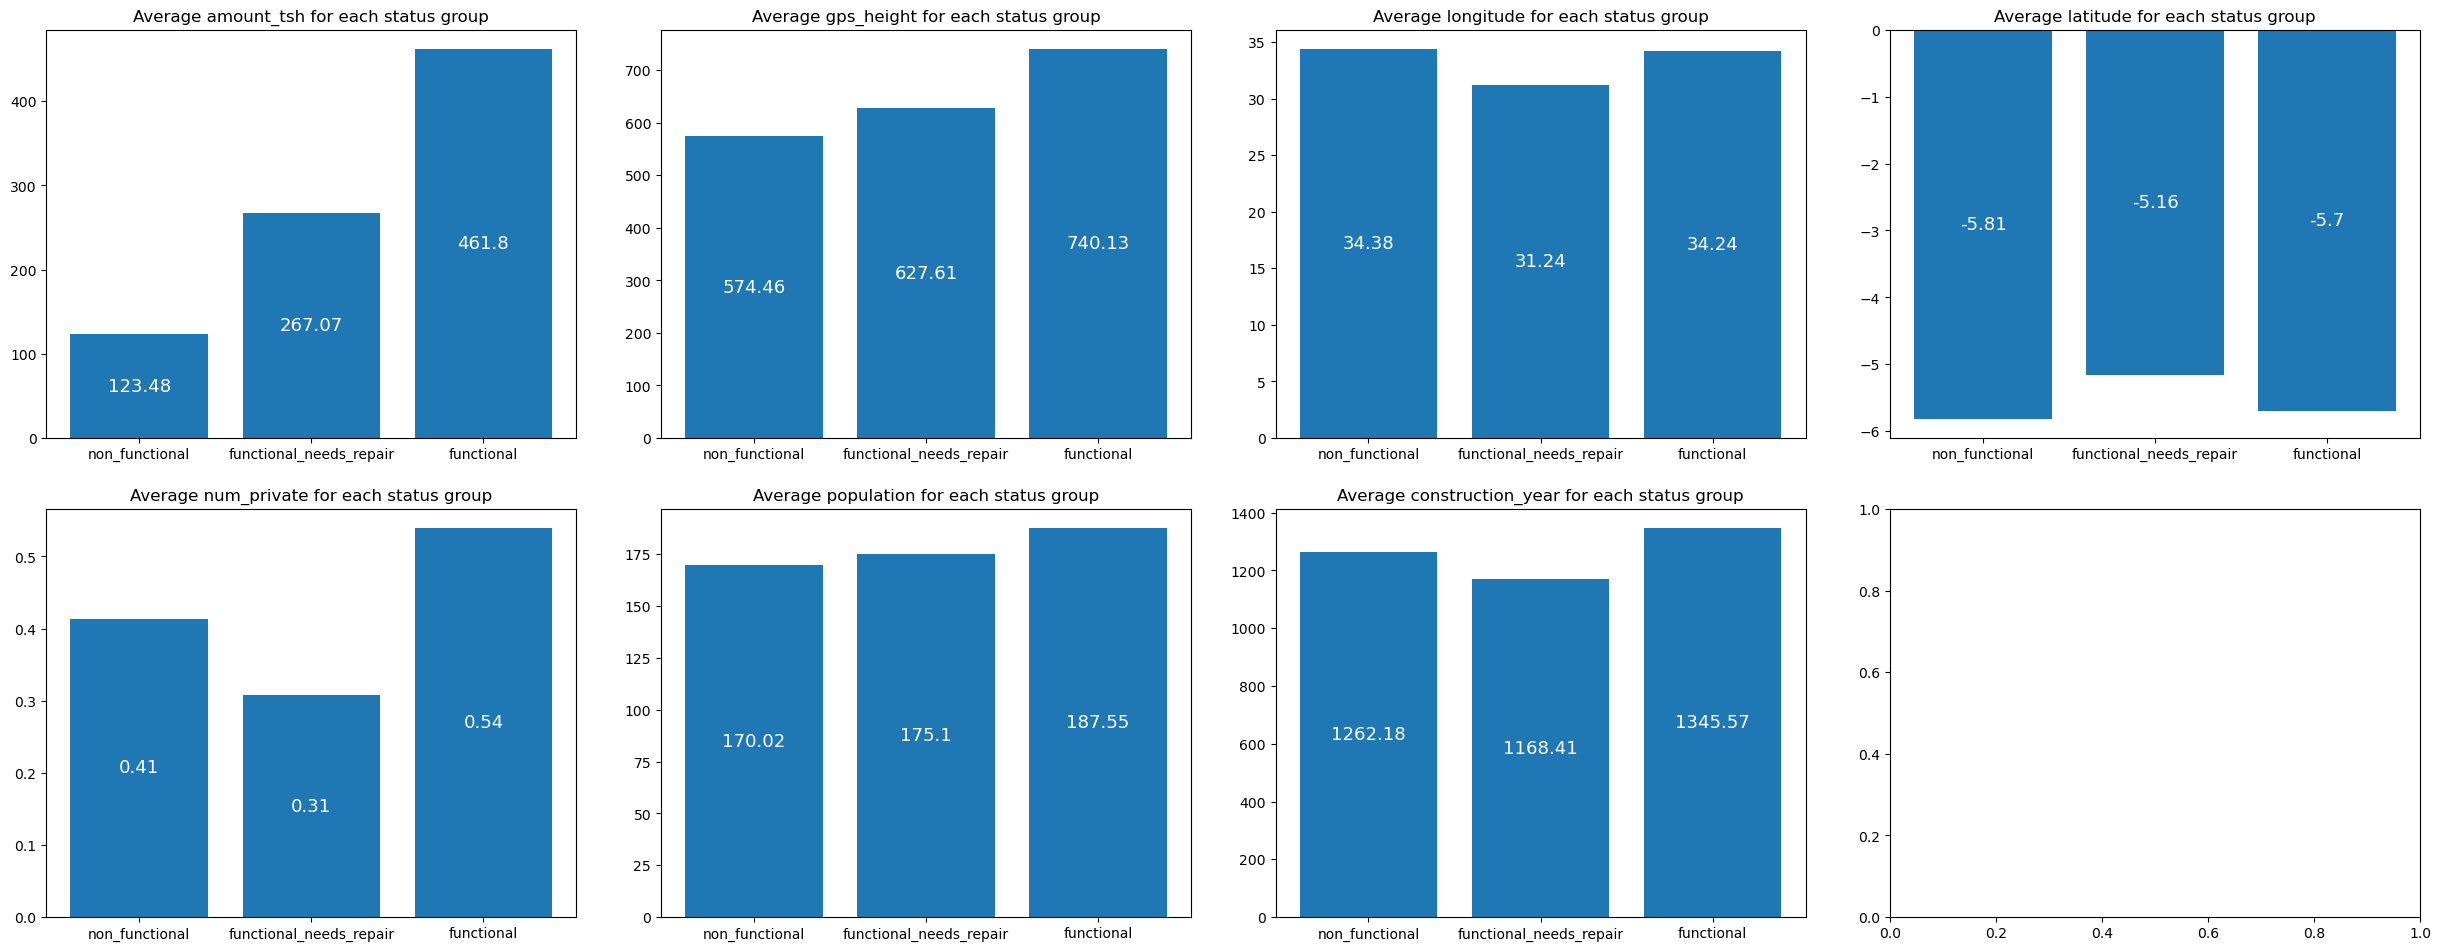

In [207]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
fig.tight_layout(pad=3)

df = pd.concat([X_numeric_copy, y], axis=1)
cols = list(X_numeric_copy.columns)

for i in range(8):
    try:
        row = i//4
        col=i%4

        non_functional = df[df.status_group==0][cols[i]].mean()
        functional_needs_repair = df[df.status_group==1][cols[i]].mean()
        functional = df[df.status_group==2][cols[i]].mean()

        means = [non_functional, functional_needs_repair, functional]
        names = ['non_functional', 'functional_needs_repair', 'functional']

        barplot = ax[row][col].bar(names, means)
        ax[row][col].bar_label(barplot, labels=[round(i,2) for i in means], label_type='center', color='white', fontsize='13');
        
        ax[row][col].set_title(f"Average {cols[i]} for each status group")
        
    except:
        break

In [229]:
X['id'] = pd.read_csv("tanzanian_water_wells/X_train.csv")['id']

lat_square, long_square = 0.01, 0.01 # Boundaries for region

for col in ['amount_tsh', 'num_private', 'population', 'construction_year']:

    vicinity_means = []

    for i in range(len(X_numeric)):
        
        copy = X[['latitude', 'longitude', col, 'id']]
        
        lat, long = X.iloc[i].latitude, X.iloc[i].longitude
        identifier = X.iloc[i].id

        area = X[(X.latitude < lat+lat_square) & 
                      (X.latitude > lat-lat_square) & 
                      (X.longitude < long+long_square) & 
                      (X.longitude > long-long_square) & 
                      (X.id != identifier)]

        vicinity_means.append(area[col].mean())

        if i%5==0:
            clear_output(wait=True)
            print(f"Engineering feature {'vicinity_' + col}.tiny Cell number {i+1} out of {len(X)} done.")
            percentage = (i+1)/len(X) * 100
            print(f"{round(percentage, 2)}% complete.")

    # Creates new column.
    X['vicinity_' + col] = vicinity_means
    
print("\n Features successfully engineered.")

X = X.drop(['id'], axis=1)

Engineering feature vicinity_construction_year.
Cell number 59396 out of 59400 done.
99.99% complete.

 Features successfully engineered.


In [230]:
X

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,lga_Arusha Urban,lga_Babati,lga_Bagamoyo,...,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,vicinity_amount_tsh,vicinity_num_private,vicinity_population,vicinity_construction_year
0,0.017143,0.517483,0.865979,0.153923,0.0,0.003574,0.993045,0,0,0,...,1,0,0,0,0,0,0.008136,0.000000,0.004355,0.991721
1,0.000000,0.520629,0.860047,0.815659,0.0,0.009180,0.998510,0,0,0,...,1,0,0,0,0,0,0.000000,0.000282,0.006082,0.973883
2,0.000071,0.271329,0.928504,0.671973,0.0,0.008197,0.998013,0,0,0,...,0,1,0,0,0,0,0.002452,0.000190,0.005676,0.970920
3,0.000000,0.123427,0.953922,0.042418,0.0,0.001902,0.986587,0,0,0,...,0,1,0,0,0,0,0.000119,0.000000,0.002770,0.954568
4,0.000000,0.031469,0.771612,0.843309,0.0,0.000000,0.000000,0,0,0,...,1,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.000029,0.454545,0.921295,0.720686,0.0,0.004098,0.993045,0,0,0,...,1,0,0,0,0,0,0.000190,0.001264,0.002692,0.982136
59396,0.013429,0.455245,0.873710,0.221368,0.0,0.001836,0.991555,0,0,0,...,1,0,0,0,0,0,0.002555,0.000000,0.002862,0.995185
59397,0.000000,0.031469,0.843151,0.248854,0.0,0.000000,0.000000,0,0,0,...,0,0,0,1,0,0,0.000190,0.000000,0.000000,0.052398
59398,0.000000,0.031469,0.888862,0.452457,0.0,0.000000,0.000000,0,0,0,...,0,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000


# Creating Test and Train Sets

The stakeholder asks us for predictions on the test set, but we do not know what the target values for this test set are (naturally – if we had those, there would be no need for the stakeholder to ask us to do this).

In order to evaluate the performance of our models, we need to create test and train sets from our complete data.

In [232]:
#Creating a train-test-split for X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=state)

In [233]:
# Resetting indices for simplicity

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Base Model – Logistic Regression, No Regularization, No Resampling

In an iterative modeling approach, we start with a very basic model and work our way up from there. Therefore, we start with a simple Logistic Regression estimator with all default settings.

In [234]:
estimator = LogisticRegression(random_state=state)
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)

pd.DataFrame(classification_report(y_test, predictions, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.775858,0.519481,0.727512,0.739731,0.674284,0.730952
recall,0.648644,0.111732,0.886886,0.739731,0.549087,0.739731
f1-score,0.706571,0.183908,0.799332,0.739731,0.563270,0.719355
support,5678.000000,1074.000000,8098.000000,0.739731,14850.000000,14850.000000


# Major Issue – Imbalance Target Categories

As you can see in the value counts of our target variable, the categories are extremely imbalanced. The category of "0", which means the waterpoint has a status of "functional needs repair," has way less values than 1 and 2, which mean "non functional" and "functional," respectively.

We can deal with this situation by introducing new artificial data points of the underrepresented category into our dataset, using SMOTE (Synthetic Minority Oversampling Technique). By default, this function gives each category the same number of occurrences as the most-frequent category, which in this case is "1" - "functional."

In [235]:
y_train.value_counts()

status_group
2    24161
0    17146
1     3243
Name: count, dtype: int64

In [236]:
#Resampling dataframes for model creation
smote = SMOTE(random_state=state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [237]:
y_train_resampled.value_counts()

status_group
0    24161
2    24161
1    24161
Name: count, dtype: int64

In [238]:
#Re-training default estimator on re-sampled data
estimator = LogisticRegression(random_state=state)
estimator.fit(X_train_resampled, y_train_resampled)
predictions = estimator.predict(X_test)

pd.DataFrame(classification_report(y_test, predictions, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.767039,0.200414,0.778984,0.643704,0.582146,0.732573
recall,0.616414,0.630354,0.664609,0.643704,0.637126,0.643704
f1-score,0.683527,0.304133,0.717265,0.643704,0.568308,0.674486
support,5678.000000,1074.000000,8098.000000,0.643704,14850.000000,14850.000000


# Analysis – Oversampling Effect

If our model is to be successful, we have to predict the "functional needs repair" instances with respectable accuracy. 13% recall is inexcusable. As we can see with our over-sampling technique, we can improve our accuracy and recall in this category significantly (the f1-score improved from 0.2 to 0.33), but it will slightly decrease our metrics in other categories (functional f1-score decreased from 0.80 to 0.74).

Testing other over-sampling ratios reveals that resampling "functional needs repair" instances to about 10-15,000 instances is ideal for predictive accuracy/recall. Our F1-score for this category tops out at around 0.33-0.34.

This still isn't good, so maybe it's time to use different estimators – e.g., random forests, gradient boosting techniques, etc.

In [240]:
strategies = {str(n): {1: n} for n in [10000, 15000, 20000]}
reports = {}

for name, strategy in strategies.items():
    
    # Re-sampling data
    smote = SMOTE(sampling_strategy = strategy, random_state=state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Training estimator on resampled data
    estimator =  LogisticRegression(random_state=state)
    estimator.fit(X_train_resampled, y_train_resampled)
    predictions = estimator.predict(X_test)

    # Generating report and formatting as a pandas DataFrame
    report = pd.DataFrame(classification_report(y_test, predictions, output_dict=True))
    
    # Adding dictionary to report
    reports[name] = report
    
for name, report in reports.items():
    display(report.style.set_caption(f"resampling strategy: {name}"))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.790847,0.282581,0.747256,0.711582,0.606895,0.730317
recall,0.608665,0.407821,0.824031,0.711582,0.613506,0.711582
f1-score,0.687898,0.333841,0.783768,0.711582,0.601836,0.714571
support,5678.000000,1074.000000,8098.000000,0.711582,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.800435,0.233744,0.752213,0.683502,0.595464,0.733154
recall,0.583480,0.512104,0.776365,0.683502,0.623983,0.683502
f1-score,0.674952,0.320980,0.764098,0.683502,0.586677,0.697965
support,5678.000000,1074.000000,8098.000000,0.683502,14850.000000,14850.000000


,0,1,2,accuracy,macro avg,weighted avg
precision,0.807992,0.209852,0.757731,0.658855,0.591858,0.737324
recall,0.566221,0.594972,0.732280,0.658855,0.631157,0.658855
f1-score,0.665838,0.310269,0.744788,0.658855,0.573632,0.683175
support,5678.000000,1074.000000,8098.000000,0.658855,14850.000000,14850.000000


# Using different estimators

We will compile results from the following estimators and arrange them in an easily-understood format:

- Logistic Regression (re-do of what we did earlier)
- K Nearest Neighbors with n=3
- K Nearest Neighbors with n=5
- K Nearest Neighbors with n=7
- Bagging Classifier with a decision tree as its base estimator
- Random Forest
- XG-Boost
- Adaboost
- Gradient Boosted Trees with a decision tree as its base estimator
- Extra Randomized Trees

In [241]:
# All the estimators to iterate through.

estimators = {'Logistic Regression': LogisticRegression(), 
              'K-Nearest Neighbors n3': KNeighborsClassifier(n_neighbors=3), 
              'K-Nearest Neighbors n5': KNeighborsClassifier(n_neighbors=5),
              'K-Nearest Neighbors n7': KNeighborsClassifier(n_neighbors=7),
              'Bagging Classifier': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, max_features=50, random_state=state), 
              'Random Forest': RandomForestClassifier(random_state=state), 
              'XG-Boost': XGBClassifier(random_state=state), 
              'Adaboost': AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=state), 
              'Gradient Boosted Trees': GradientBoostingClassifier(n_estimators=200, max_features=50, random_state=state), 
              'Extra Randomized Trees': ExtraTreesClassifier(n_estimators=100, random_state=state)}

In [246]:
# {1: 3243} – just the original dataset
# {1: 10000} – increasing instances of functional needs repair to 10,000
# {1: 15000} – increasing instances of functional needs repair to 15,000
# {1: 20000} – increasing instances of functional needs repair to 20,000
# auto – increasing instances of functional needs repair to whatever the most frequent class has

resampled_datasets = {str(n): SMOTE(sampling_strategy=n, random_state=state).fit_resample(X_train, y_train) for n in [{1: 3243}, {1: 10000}, {1: 15000}, {1: 20000}, 'auto']}
resampled_datasets = [(name, key[0], key[1]) for name, key in resampled_datasets.items()]

In [247]:
# Dictionary for our results
results_dict = {name: None for name in estimators.keys()}

for name, estimator in estimators.items():
    
    # Helpful ticker #1
    print(f"Estimator: {name}")
    
    results = {}
    
    for ratio, ratio_X, ratio_y in resampled_datasets:
        
        # Helpful ticker #2
        print(f"Sampling ratio: {ratio}")
        
        est = estimator
        est.fit(ratio_X, ratio_y)
        predictions = est.predict(X_test)
        
        report = pd.DataFrame(classification_report(y_test, predictions, output_dict=True))
        matrix = pd.DataFrame(confusion_matrix(y_test, predictions))
        
        # For this particular estimator and resampled dataset, we are recording:
        # 1) Our predictions, 2) Classification report, and 3) Confusion matrix
        results[ratio] = (predictions, report, matrix)
        
    results_dict[name] = results
    clear_output(wait=True)

Estimator: Logistic Regression
Sampling ratio: {1: 3243}


ValueError: Length of values (3) does not match length of index (4)

In [ ]:
# Prettifies our results

print("\n")
for name, results in results_dict.items():
    print(color.BOLD + name + color.END)
    
    for ratio, tup in results.items():
        display(tup[1].style.set_caption(f"resampled data (n = {ratio})"))
    print("\n\n")

# Comparing our best model and our base model

Our first model was a default Logistic Regression estimator. Our best model was the Random Forest with a resampling ratio of 10,000. We will now look at the metrics, confusion matrices, and ROC curves of these models side-by-side.

In [ ]:
base_preds = results_dict['Logistic Regression']['{0: 3243}'][0]
best_preds = results_dict['Random Forest']['{0: 10000}'][0]

base_report = classification_report(y_test, base_preds, output_dict=True)
best_report = classification_report(y_test, best_preds, output_dict=True)

base_report_df = pd.DataFrame(base_report)
best_report_df = pd.DataFrame(best_report)

display (base_report_df.style.set_caption("base model"))
display (best_report_df.style.set_caption("best model"))

# Evaluating our models in-depth

There are several different ways we can gauge the performance of our models. On their own, precision and recall offer limited insight into a model's performance. The f1-score, however, is a balanced average of both metrics and is much more complete measure of model success.

Overall accuracy is also a useful metric, but I would not use it on its own; it doesn't break model performance down by category.

The AUC score has a maximum score of 1.

The ROC curve is a popular visualization of model performance.

### OVR ROC curves

In [ ]:
maps = [{0:1, 1:0, 2:0}, 
        {0:0, 1:1, 2:0}, 
        {0:0, 1:0, 2:1}]

namez = [f"OVR - Reference class: {Category}" for Category in ['non functional', 'functional needs repair', 'functional']]

In [ ]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, ax = plt.subplots(2,2, figsize=(15,10))

xdatas, ydatas = [], []

for i in [0,1,2]:
    
    row = i//2
    col=i%2
    
    ovr_test = list(y_test.replace(maps[i]))
    ovr_train = list(y_train.replace(maps[i]))
    
    est = LogisticRegression(random_state=state)
    est.fit(X_train, ovr_train)
    
    plot = RocCurveDisplay.from_estimator(est, X_test, ovr_test, ax=ax[row][col], name=namez[i]).line_
    
    xdata = plot.get_xdata()
    ydata = plot.get_ydata()
    
    xdatas.append(xdata)
    ydatas.append(ydata)
    
    plt.close(fig)

In [ ]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, ax = plt.subplots(2,2, figsize=(15,10))

xdatas2, ydatas2 = [], []

for i in [0,1,2]:
    
    row = i//2
    col=i%2
    
    ovr_test = list(y_test.replace(maps[i]))
    ovr_train = list(resampled_datasets[1][2].replace(maps[i]))
    
    est = RandomForestClassifier(random_state=state)
    est.fit(resampled_datasets[1][1], ovr_train)
    
    plot = RocCurveDisplay.from_estimator(est, X_test, ovr_test, ax=ax[row][col], name=namez[i]).line_
    xdata = plot.get_xdata()
    ydata = plot.get_ydata()
    
    xdatas2.append(xdata)
    ydatas2.append(ydata)
    
    plt.close(fig)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

for i in [0,1,2]:
    
    row = i//2
    col=i%2
    
    ax[row][col].plot(xdatas[i], ydatas[i], color='blue', label=f"Logistic Regression – AUC: {auc(xdatas[i], ydatas[i])}")
    ax[row][col].plot(xdatas2[i], ydatas2[i], color='pink', label=f"Random Forest – AUC: {auc(xdatas2[i], ydatas2[i])}")
    
    ax[row][col].set_title(namez[i])
    
    ax[row][col].legend(loc=4)

### Comparing F1 Scores between models

In [ ]:
f1_scores = [base_report['0']['f1-score'], best_report['0']['f1-score']]

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("F1 scores for Non Functional")
barplot = ax.bar(['Logistic Regression', 'Random Forest \n with Resampling'], f1_scores)
ax.bar_label(barplot, labels=[round(i,2) for i in f1_scores], label_type='center', color='white', fontsize='13');
ax.set_ylim(0,1)

In [ ]:
f1_scores = [base_report['1']['f1-score'], best_report['1']['f1-score']]

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("F1 scores for Functional Needs Repair category")
barplot = ax.bar(['Logistic Regression', 'Random Forest \n with Resampling'], f1_scores)
ax.bar_label(barplot, labels=[round(i,2) for i in f1_scores], label_type='center', color='white', fontsize='13');
ax.set_ylim(0,1)

In [ ]:
f1_scores = [base_report['2']['f1-score'], best_report['2']['f1-score']]

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("F1 scores for Functional")
barplot = ax.bar(['Logistic Regression', 'Random Forest \n with Resampling'], f1_scores)
ax.bar_label(barplot, labels=[round(i,2) for i in f1_scores], label_type='center', color='white', fontsize='13');
ax.set_ylim(0,1)